In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import month_plot, quarter_plot,\
                                           plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
                            root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel

In [28]:
df = pd.read_csv('electricity.csv', index_col='ds', parse_dates=True)
df = df.query('unique_id == "DE"')
df = df.asfreq('h')
df

,unique_id,y,Exogenous1,Exogenous2
ds,,,,
2017-10-22 00:00:00,DE,19.10,587.25,16972.75
2017-10-22 01:00:00,DE,19.03,623.00,16254.50
2017-10-22 02:00:00,DE,16.90,650.00,15940.25
2017-10-22 03:00:00,DE,12.98,687.25,15959.50
2017-10-22 04:00:00,DE,9.24,717.25,16071.50
...,...,...,...,...
2017-12-30 19:00:00,DE,16.18,1519.50,19326.00
2017-12-30 20:00:00,DE,11.13,1526.75,18135.25
2017-12-30 21:00:00,DE,4.62,1514.75,17631.50


Exploratory Data Analysis

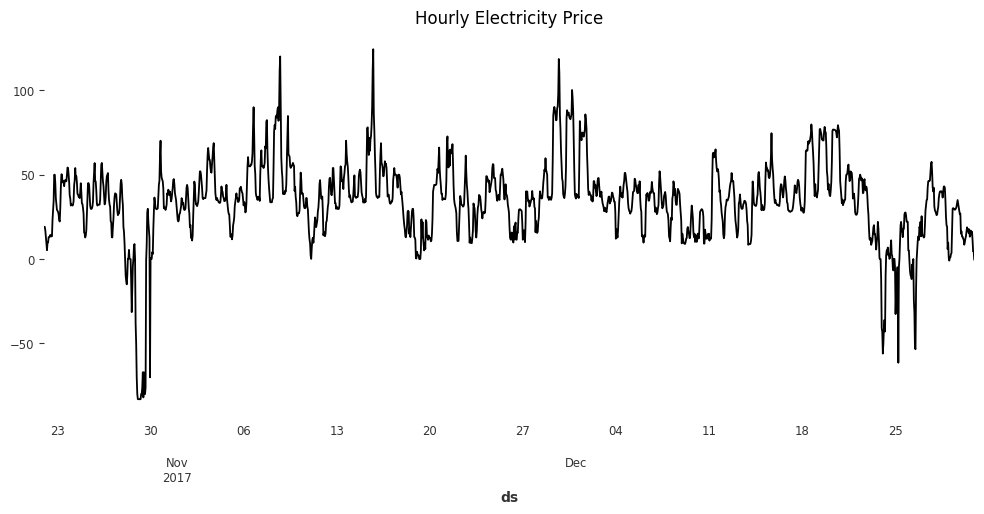

In [35]:
fig = plt.figure(figsize=(12, 5))
df['y'].plot(title='Hourly Electricity Price')
plt.grid('')
plt.show()

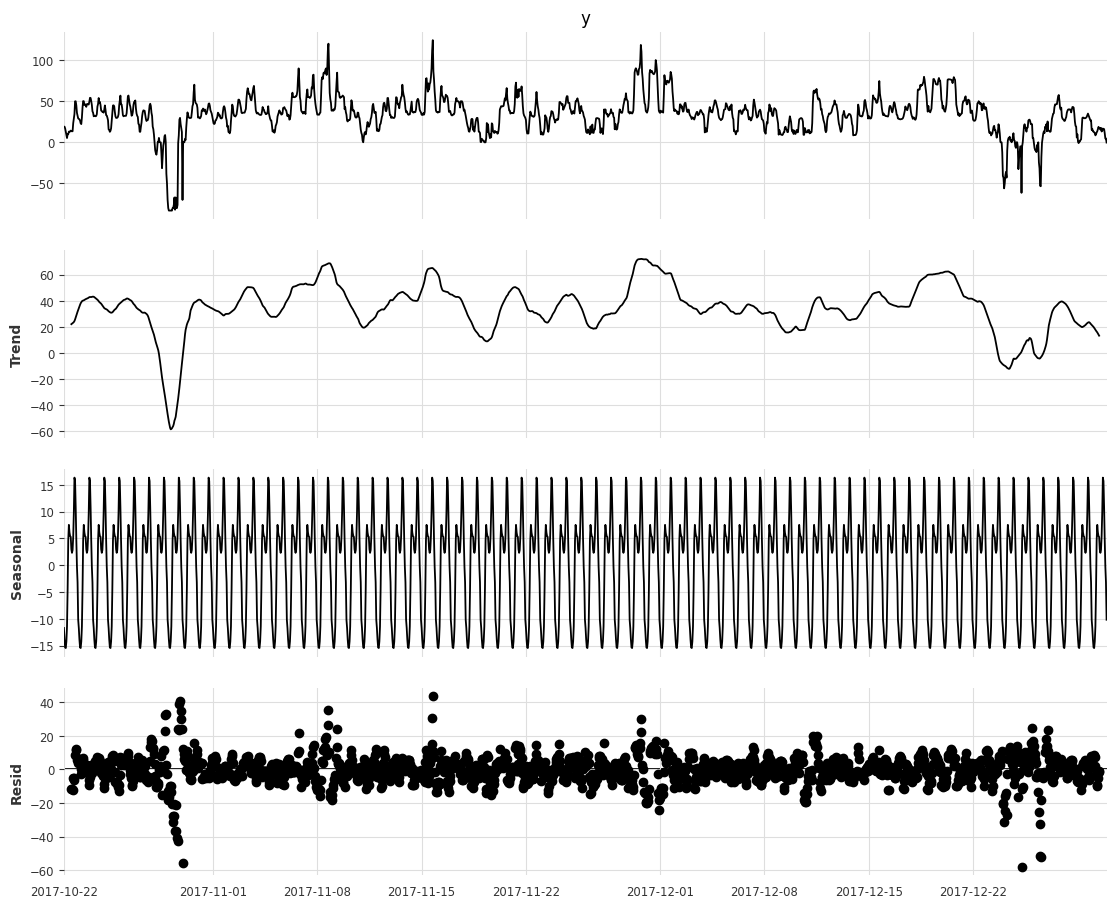

In [48]:
decomposition = seasonal_decompose(df['y'], model='add', period=24)


fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

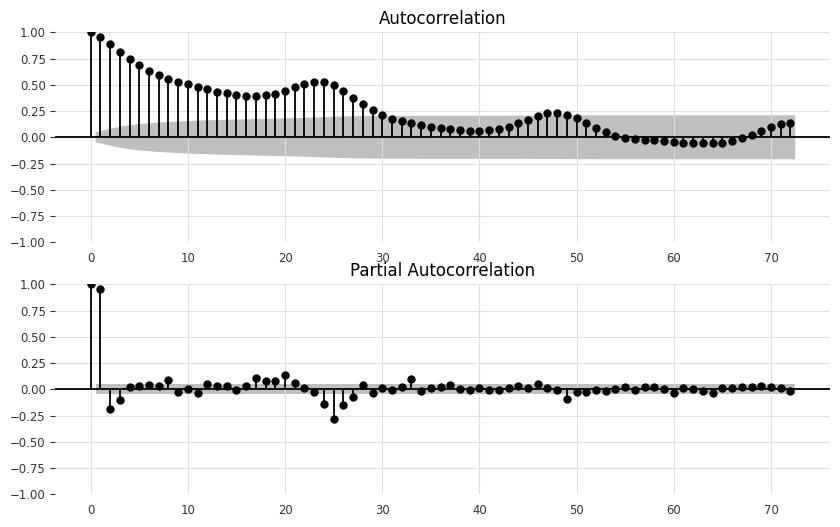

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(df['y'], lags=72, ax=ax[0])
plot_pacf(df['y'], lags=72, ax=ax[1])
plt.show()

In [50]:
series = TimeSeries.from_dataframe(df, value_cols='y')
series

<TimeSeries (DataArray) (ds: 1680, component: 1, sample: 1)> Size: 13kB
array([[[19.1 ]],

       [[19.03]],

       [[16.9 ]],

       ...,

       [[ 4.62]],

       [[ 4.71]],

       [[-0.27]]])
Coordinates:
  * ds         (ds) datetime64[ns] 13kB 2017-10-22 ... 2017-12-30T23:00:00
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [51]:
def encode_year(idx):
    return(idx.year - 2000) / 50

add_encoders = {
    'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'datetime_attribute': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'CET'}

Past Covariates

In [52]:
X_past = df.iloc[:, 2:]
past_covariates = TimeSeries.from_dataframe(X_past)

past_covariates

<TimeSeries (DataArray) (ds: 1680, component: 2, sample: 1)> Size: 27kB
array([[[  587.25],
        [16972.75]],

       [[  623.  ],
        [16254.5 ]],

       [[  650.  ],
        [15940.25]],

       ...,

       [[ 1514.75],
        [17631.5 ]],

       [[ 1484.75],
        [17553.75]],

       [[ 1440.75],
        [16754.5 ]]])
Coordinates:
  * ds         (ds) datetime64[ns] 13kB 2017-10-22 ... 2017-12-30T23:00:00
  * component  (component) object 16B 'Exogenous1' 'Exogenous2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Future Covariates

In [59]:
future_df = pd.read_csv('electricity-future.csv', 
                        index_col='ds', 
                        parse_dates=True)

future_df = future_df.query('unique_id == "DE"')
X_future = future_df.iloc[:, 1:]

X = pd.concat([X_past, X_future])

future_covariates = TimeSeries.from_dataframe(X)

In [61]:
scaler_y = Scaler()
scaler_covariates = Scaler()

y_transformed = scaler_y.fit_transform(series)

past_covariates_transformed = scaler_covariates.fit_transform(past_covariates)
future_covariates_transformed = scaler_covariates.fit_transform(future_covariates)

TFT Model

In [ ]:
model = TFTModel(
    input_chunk_length = 96,
    output_chunk_length = 24,
    hidden_size = 16,
    lstm_layers = 2,
    num_attention_heads = 4,
    dropout = 0.1,
    batch_size = 64,
    n_epochs = 10,
    add_encoders = add_encoders,
    use_static_covariates = True,
    pl_trainer_kwargs = {'accelerator': 'cpu'}
)

model.fit(
    y_transformed,
    past_covariates = past_covariates_transformed,
    future_covariates = future_covariates_transformed
)